# Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr as corr
from scipy.stats import ttest_ind as tt

choice_data_dprime_threeRounds=np.load('data_dprime_cleaned.npy')
criteria_inclusion=np.load('subs_not_meet_criteria_combined_pop_lik_posttask_qs.npy')
choice_data=np.load('data_justknown_subs.npy')
gender=np.load('gender_87subs.npy')
criteria_inclusion=list(criteria_inclusion)
choice_data_red=np.delete(choice_data,criteria_inclusion,axis=0)
choice_data_dprime_threeRounds=choice_data_red
print(choice_data_dprime_threeRounds.shape)

#just subjects who know peers
lik_red=np.load('likeable_subs_allthree_known.npy')
lik_red=lik_red+1
lik_red=np.delete(lik_red,criteria_inclusion)
# cd=np.reshape(choice_data_dprime_threeRounds,(1161,1))
# choice_data_dprime_threeRounds=(choice_data_dprime_threeRounds-np.mean(choice_data_dprime_threeRounds))/np.std(choice_data_dprime_threeRounds)
print('averages across conditions:\n baseline:    unpopular:     popular:')
print(np.mean(np.mean(choice_data_dprime_threeRounds,axis=0),axis=1))
print('')
print('')
print('std dev baseline')
print(np.std((choice_data_dprime_threeRounds[:,0,0]+choice_data_dprime_threeRounds[:,0,1]+choice_data_dprime_threeRounds[:,0,2])/3.0))
print('std dev high')
print(np.std((choice_data_dprime_threeRounds[:,2,0]+choice_data_dprime_threeRounds[:,2,1]+choice_data_dprime_threeRounds[:,2,2])/3.0))
print('std dev low')
print(np.std((choice_data_dprime_threeRounds[:,1,0]+choice_data_dprime_threeRounds[:,1,1]+choice_data_dprime_threeRounds[:,1,2])/3.0))
order=np.load('order_variable.npy')
print(order)
print('length of order variable: {}'.format(len(order)))
likeable_threegroups=np.load('likeable_subs_allthree.npy')
likeable_threegroups=likeable_threegroups+1 # rescale to 0,1,2 encoding 


bl=(choice_data_dprime_threeRounds[:,0,0]+choice_data_dprime_threeRounds[:,0,1]+choice_data_dprime_threeRounds[:,0,2])/3.0
unpop=(choice_data_dprime_threeRounds[:,1,0]+choice_data_dprime_threeRounds[:,1,1]+choice_data_dprime_threeRounds[:,1,2])/3.0
pop=(choice_data_dprime_threeRounds[:,2,0]+choice_data_dprime_threeRounds[:,2,1]+choice_data_dprime_threeRounds[:,2,2])/3.0
x=pd.DataFrame(bl)
x=x.rename(columns={0:'bl'})
x['unpop']=unpop
x['pop']=pop

r,p=corr(bl,unpop)
print('corr bl unpop: {}'.format(r,p))
r,p=corr(bl,pop)
print('corr bl pop: {}'.format(r,p))
r,p=corr(pop,unpop)
print('corr pop unpop: {}'.format(r,p))

x['grouping']=gender
print('full group means:')
print(x.mean())
print('')
print('full group SDs')
print(x.std())
print('')
print('')
print('group means:')
print(x.groupby(['grouping']).mean())
print('')
print('group SDs')
print(x.groupby(['grouping']).std())
print('')
print('group sizes:')
print(x.groupby(['grouping']).size())
print('')

males=x[x['grouping']==0]
females=x[x['grouping']==1]

males_avg_performance=males['bl']
females_avg_performance=females['bl']
# males_avg_performance.columns=['avg']
# females_avg_performance.columns=['avg']

# print(males_avg_performance.columns)
t,p=tt(males_avg_performance.tolist(),females_avg_performance.tolist())
print('{} and pvalue:{} for gender difference'.format(t,p))

pop_red=np.load('popularity_subs_allthree_known.npy')
pop_red=pop_red+1

criteria_inclusion=np.load('subs_not_meet_criteria_combined_pop_lik_posttask_qs.npy')
criteria_inclusion=list(criteria_inclusion)
indices_subs_lik_unpop_more=[]
counter=0
for i in range(len(lik_red)):
    if lik_red[i]==0:
        indices_subs_lik_unpop_more.append(counter)
    elif pop_red[i]==0:
        indices_subs_lik_unpop_more.append(counter)
    counter+=1
print(indices_subs_lik_unpop_more)
print(len(indices_subs_lik_unpop_more))
choice_data=np.load('data_justknown_subs.npy')
choice_data_red=np.delete(choice_data,criteria_inclusion,axis=0)
choice_data_red_nobaseline=np.delete(choice_data_red,0,axis=1)
print(choice_data_red_nobaseline.shape)
soc_stats=np.load('socstat_87subs.npy')

order_red=np.load('order_variable_fixed.npy')
order_ns=np.delete(order_red,criteria_inclusion)
print('number order 1: {}'.format(np.sum(order_ns)))
print('Number subjects: {}'.format(len(choice_data)))
print('Number subjects reduced: {}'.format(len(choice_data_red)))

(87, 3, 3)
averages across conditions:
 baseline:    unpopular:     popular:
[1.80963384 2.03390665 2.24178744]


std dev baseline
0.7743213546481194
std dev high
0.9871214142157004
std dev low
1.0779641843214254
[1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0
 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1]
length of order variable: 129
corr bl unpop: 0.3332664377890428
corr bl pop: 0.5138453781545107
corr pop unpop: 0.5032581741321941
full group means:
bl          1.809634
unpop       2.033907
pop         2.241787
grouping    0.494253
dtype: float64

full group SDs
bl          0.778810
unpop       1.084213
pop         0.992844
grouping    0.502865
dtype: float64


group means:
                bl     unpop       pop
grouping                              
0         1.864623  2.056846  2.332086
1         1.753366  2.010434 

# Calculate scaled priors

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

ySD=np.std(choice_data_dprime_threeRounds)
yMean=np.mean(choice_data_dprime_threeRounds)
gammas, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
bl_sd=1/((ySD*5)**2)
print(bl_sd)
noise=[ySD/100,ySD*10]
print(ySD*0.1)
print(noise)
print(gammas)
print(rate)




0.02732665679262992
0.12098645298264149
[0.012098645298264148, 12.098645298264149]
1.2831955546343297
0.46814423871895994


# Model: condition, subject, group & interaction of group and condition

#### For model below, i=condition, j=subject, k=block,g=group

$data_{i,k,j} \sim \mathcal{N}(theta_{i,k,j},noise)$

$noise \sim U(0.01,10)$ Error term

$\theta_{i,k,j}= baseline+subjectIntercept_{j}+conditionEffect_{i}\$

$subjectIntercept_{j} \sim \mathcal{N}(\mu_{data},\sigma_{subject})$

$baseline \sim \mathcal{N}(0,5)$

$\sigma_{subject} \sim U(0,\sigma_{S})$

$ConditionEffect \sim \mathcal{N}(0,\sigma_{W})$

$\sigma_{all} \sim \mathcal{G}(1.28,0.56)$


# Order effects (i.e., no baseline)

In [13]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> order[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  
  //interaction order and condition
  matrix[2,2] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  
  //order variable
  vector[2] orderv;
  
  
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (order[k]==0){
            theta_popular[k] =  a0+aS[k]+aCondition[1]+orderv[2]+aInteraction[1,2];
            theta_unpopular[k] = a0+aS[k]+aCondition[2]+orderv[1]+aInteraction[2,1];}
        else if (order[k]==1){
            theta_popular[k] = a0+aS[k]+aCondition[1]+orderv[1]+aInteraction[1,1];
            theta_unpopular[k] = a0+aS[k]+aCondition[2]+orderv[2]+aInteraction[2,2];
        }
        }
        
    
}
model {    
    
    
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    aCondition ~ normal(0,1);
    orderv ~normal(0,1);
    aInteraction[:,1] ~ normal(0,1);
    aInteraction[:,2] ~ normal(0,1);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.10);
    noise ~ uniform(0.10,12);
   
    
    
    for (k in 1:NxSubjects){
    
       
        // unpopular condition
        Choice[k,1,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,2,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_red_nobaseline,#choice data
              'NxConditions':2,
              'NxSubjects':87,
              'NxBlocks':3,
              'order':order_ns
              
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n_red = StanModel(model_code=model_input_n)
fit_3dprime_interaction_red = model_fit_n_red.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a71f30749894afcf455174cec2ebe611 NOW.


In [9]:
print(fit_3dprime_interaction_red)

Inference for Stan model: anon_model_a71f30749894afcf455174cec2ebe611.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aS[1]                -0.18  6.1e-3   0.38  -0.92  -0.43  -0.18   0.08   0.56   3902    1.0
aS[2]                -0.07  5.8e-3   0.38   -0.8  -0.31  -0.07   0.19   0.67   4132    1.0
aS[3]                 0.38  4.9e-3   0.37  -0.33   0.13   0.38   0.64    1.1   5567    1.0
aS[4]                 1.08  5.9e-3   0.37   0.34   0.82   1.08   1.33    1.8   4006    1.0
aS[5]                -0.51  5.6e-3   0.38  -1.28  -0.76   -0.5  -0.25   0.24   4586    1.0
aS[6]                -0.58  5.3e-3   0.36  -1.27  -0.84  -0.59  -0.34   0.15   4653    1.0
aS[7]                 0.68  5.8e-3   0.37  -0.04   0.42   0.68   0.93   1.39   3994    1.0
aS[8]                -0.86  6.3e-3   0.38  -1.62  -1.12  -0.86   -0.6  -0.12   3659

# Status model with subjects who knew peers (n=87)

In [3]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real socstat[NxSubjects];
    real<lower=0> Choice[NxSubjects, NxConditions,NxBlocks];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  
  real beta;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
  
            theta_baseline[k] = a0+aS[k]+aCondition[1]+beta*socstat[k];
            theta_popular[k] =  a0+aS[k]+aCondition[2]+beta*socstat[k];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+beta*socstat[k];

        }
        
    
}
model {    
    
    
    sigmaS ~gamma(1.28, 0.47);
    aCondition ~ normal(0,1);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.10);
    beta ~ normal(0,1);
    noise ~ uniform(0.10,12);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_red,#choice data
              'socstat':soc_stats,
              'NxConditions':3,
              'NxSubjects':87,
              'NxBlocks':3,              
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n_red = StanModel(model_code=model_input_n)
fit_3dprime_interaction_red_noorder = model_fit_n_red.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d9602ce0c2fb886f8edc6f346724cfe NOW.


In [4]:
print(fit_3dprime_interaction_red_noorder)

Inference for Stan model: anon_model_4d9602ce0c2fb886f8edc6f346724cfe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
aS[1]                -0.14  5.0e-3   0.31   -0.74   -0.34  -0.13   0.07   0.45   3731    1.0
aS[2]                -0.07  4.7e-3   0.31   -0.68   -0.28  -0.08   0.13   0.55   4221    1.0
aS[3]                 0.35  4.6e-3    0.3   -0.25    0.15   0.35   0.55   0.96   4246    1.0
aS[4]                 1.16  4.8e-3   0.31    0.57    0.95   1.17   1.37   1.76   4221    1.0
aS[5]                -0.04  5.0e-3   0.31   -0.65   -0.25  -0.04   0.17   0.58   3891    1.0
aS[6]                 -0.5  4.6e-3    0.3   -1.09    -0.7   -0.5   -0.3   0.09   4169    1.0
aS[7]                  0.5  4.6e-3    0.3    -0.1     0.3   0.49    0.7   1.09   4339    1.0
aS[8]                -0.76  4.7e-3    0.3   -1.34   -0.96  -0.76  -

# Status model contrasts on subjects who knew peers (n=87)

ms shape
(87, 2, 4000)
mBxW shape
(2, 2, 4000)
mb shape
(2, 1, 4000)
bB shape
(2, 4000)
mB squeeze
[[2.11785168 2.14532329 2.05291598 ... 2.20721032 2.16241611 2.15657121]]
bS shape
(87, 2, 4000)
percentage of parameters above 0 = 0.98425

95% CI for pop - unpop: [0.010265505991423396,0.3409105575118794]
mode of dist = 4.161418760150134
index of mode: =64
mode of x value: = 0.19554117229944318


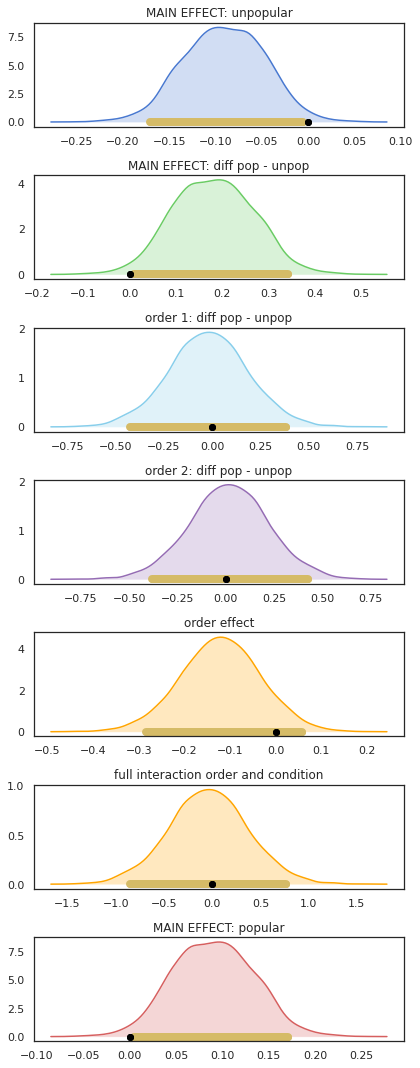

In [8]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

fit_df_2 = fit_3dprime_interaction_red.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=87
NxWithinLvl=2
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxW = np.zeros((NxSubjectLvl, NxWithinLvl, NxSamples))
mSxBxW = np.zeros((NxSubjectLvl, 2, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(2): #order effects
            exec('mu = fit_df_2["a0"] + fit_df_2["aCondition[{}]"] + fit_df_2["orderv[{}]"]+fit_df_2["aInteraction[{},{}]"] + fit_df_2["aS[{}]"]'.format(i+1,j+1,i+1,j+1,k+1))
            mSxBxW[k,j,i,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
print('ms shape')
print(mS.data.shape)

# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
print('mBxW shape')
print(mBxW.data.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
print('mb shape')
print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
# print('mw shape')
# print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
print('bB shape')
print(bB.shape)

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()
print('mB squeeze')
print(mB.squeeze()[1:10])
print('bS shape')
print(bS.shape)

#Extract data
# print('MEAN: {}'.format(m))
# mbase1 = bW[0,:]
# # print('mean bl')
# # print(np.mean(mbase1))
mpop1 = bW[0,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[1,:]
# print('mean unpop')
# print(np.mean(munpop1))

group1=bB[0,:]
group2=bB[1,:]
diff_ord=group1-group2

# base1 = bBxW[0,0,:]
pop1 = bBxW[0,0,:]
unpop1 = bBxW[0,1,:]
diff_order1=pop1-unpop1

# base2 = bBxW[1,0,:]
pop2 = bBxW[1,0,:]
unpop2 = bBxW[1,1,:]
# diff_base=base2-base1
diff_order2=pop2-unpop2

diff_across_ords=diff_order1-diff_order2

# mpop_dBase1 = mpop1-mbase1
# munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

rope=0.0

z=0
for i in mdiff_pop_unpop1:
    if i>rope:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(mdiff_pop_unpop1))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop1)
ml_cp, mr_cp = highest_density_interval(munpop1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)
ml_e, mr_e = highest_density_interval(diff_order1)
ml_f, mr_f = highest_density_interval(diff_order2)
ml_c, mr_c = highest_density_interval(diff_ord)
ml_r, mr_r = highest_density_interval(diff_across_ords)
# ml_b, mr_b = highest_density_interval(diff_base)

print('95% CI for pop - unpop: [{},{}]'.format(ml_d, mr_d))

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(7, 1, figsize=(6, 15),sharex=False)


ax1=sns.distplot(munpop1, hist=False,kde_kws={"shade": True},color="b", ax=axs[0])
ax1.set(title='MAIN EFFECT: unpopular',xlabel='')

axs[0].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

x,y = ax1.get_lines()[0].get_data()
y=list(y)
x=list(x)
mode= max(y)
index_mode=y.index(max(y))
print('mode of dist = {}'.format(mode))
print('index of mode: ={}'.format(index_mode))
print('mode of x value: = {}'.format(x[index_mode]))

axs[1].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_order1, hist=False,kde_kws={"shade": True},color="skyblue", ax=axs[2])
ax1.set(title='order 1: diff pop - unpop',xlabel='')

axs[2].plot([ml_e, mr_e],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_order2, hist=False,kde_kws={"shade": True},color="m", ax=axs[3])
ax1.set(title='order 2: diff pop - unpop',xlabel='')

axs[3].plot([ml_f, mr_f],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax1=sns.distplot(diff_ord, hist=False,kde_kws={"shade": True},color="orange", ax=axs[4])
ax1.set(title='order effect',xlabel='')

axs[4].plot([ml_c, mr_c],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_across_ords, hist=False,kde_kws={"shade": True},color="orange", ax=axs[5])
ax1.set(title='full interaction order and condition',xlabel='')

axs[5].plot([ml_r, mr_r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(mpop1, hist=False,kde_kws={"shade": True},color="r", ax=axs[6])
ax0.set(title='MAIN EFFECT: popular',xlabel='')

axs[6].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[6].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

plt.tight_layout()
plt.savefig('order_models_highres.png', dpi=300)

plt.show()


In [ ]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np


fit_df_2 = fit_3dprime_interaction_red_noorder.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=87
NxWithinLvl=3
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxW = np.zeros((NxSubjectLvl, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        exec('mu = fit_df_2["a0"] + fit_df_2["aCondition[{}]"] + fit_df_2["aS[{}]"]+fit_df_2["beta"]*soc_stats[{}]'.format(i+1,k+1,k))
        mSxW[k,i,:] = mu

# Convert to masked array that masks value '0'.
mSxW_ma = ma.masked_equal(mSxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W
mS = ma.mean(mSxW_ma, axis=(1))
print('ms shape')
print(mS.data.shape)
mW = ma.mean(mSxW_ma, axis=(0))
print('mW shape')
print(mW.data.shape)

# Equation 20.3
m = ma.mean(mSxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.7
bS = mS.squeeze() - m

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1


# z=0
# for i in mdiff_pop_unpop1:
#     if i>.023:
#         z+=1
# print('percentage of parameters above 0 = {}'.format((z/len(pop_diff))))
# print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)


rope=0.014

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(3, 1, figsize=(6, 6),sharex=False)

ax1=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[1])
ax1.set(title='High Status - Baseline',xlabel='')
x,y = ax1.get_lines()[0].get_data()
y=list(y)
x=list(x)
mode= max(y)
index_mode=y.index(max(y))
print('mode of dist = {}'.format(mode))
print('index of mode: ={}'.format(index_mode))
print('mode of x value: = {}'.format(x[index_mode]))
print('95% CI for pop - unpop: [{},{}]'.format(ml_ct, mr_ct))

axs[1].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[1].axvline(x= 0.432, color = 'r',linewidth=4.0)


ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[2])
ax1.set(title='Low Status - Baseline',xlabel='')
x,y = ax1.get_lines()[0].get_data()
y=list(y)
x=list(x)
mode= max(y)
index_mode=y.index(max(y))
print('mode of dist = {}'.format(mode))
print('index of mode: ={}'.format(index_mode))
print('mode of x value: = {}'.format(x[index_mode]))
print('95% CI for pop - unpop: [{},{}]'.format(ml_cp, mr_cp))

axs[2].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[2].axvline(x= 0.227, color = 'r',linewidth=4.0)
axs[2].set_xlabel('Parameter Estimate')
ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[0])
ax1.set(title='High Status - Low Status',xlabel='')

x,y = ax1.get_lines()[0].get_data()
y=list(y)
x=list(x)
mode= max(y)
index_mode=y.index(max(y))
print('mode of dist = {}'.format(mode))
print('index of mode: ={}'.format(index_mode))
print('mode of x value: = {}'.format(x[index_mode]))
print('95% CI for pop - unpop: [{},{}]'.format(ml_d, mr_d))

axs[0].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[0].axvline(x= 0.216, color = 'r',linewidth=4.0)
sns.set(context='notebook',style='white',palette='deep',font_scale=2.0,color_codes=True,rc=None)

plt.tight_layout()
plt.savefig('no_order_models_highres_covarying_own_social_stats.png', dpi=300)
plt.show()


ms shape
(87, 4000)
mW shape
(3, 4000)
mode of dist = 4.748553075403276
index of mode: =65
mode of x value: = 0.43276851723761167
95% CI for pop - unpop: [0.2664278641387656,0.6034551691199312]
mode of dist = 4.740024730263395
index of mode: =63
mode of x value: = 0.2272156132019283
95% CI for pop - unpop: [0.05935407326876985,0.393602575694211]
mode of dist = 4.653528359631743
index of mode: =62
mode of x value: = 0.21629539356119726
95% CI for pop - unpop: [0.04056122399249418,0.37252419841022233]
